## Chapter 18 - Metric Predicted Variable with Multiple Metric Predictors

- [18.1 - Multiple Linear Regression](#18.1---Multiple-Linear-Regression)
 - [18.1.4 - Redundant predictors](#18.1.4---Redundant-predictors)
- [18.2 - Multiplicative Interaction of Metric Predictors](#18.2---Multiplicative-Interaction-of-Metric-Predictors)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'
f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn

matplotlib: 3.5.1
numpy     : 1.22.3
pandas    : 1.4.1
pymc      : 4.0.0b6
seaborn   : 0.11.2



### 18.1 - Multiple Linear Regression
#### Data

In [3]:
df = pd.read_csv('data/Guber1999data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Spend      50 non-null     float64
 2   StuTeaRat  50 non-null     float64
 3   Salary     50 non-null     float64
 4   PrcntTake  50 non-null     int64  
 5   SATV       50 non-null     int64  
 6   SATM       50 non-null     int64  
 7   SATT       50 non-null     int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.2+ KB


In [4]:
df.head()

,State,Spend,StuTeaRat,Salary,PrcntTake,SATV,SATM,SATT
0,Alabama,4.405,17.2,31.144,8,491,538,1029
1,Alaska,8.963,17.6,47.951,47,445,489,934
2,Arizona,4.778,19.3,32.175,27,448,496,944
3,Arkansas,4.459,17.1,28.934,6,482,523,1005
4,California,4.992,24.0,41.078,45,417,485,902


In [5]:
X = df[['Spend', 'PrcntTake']]
y = df['SATT']

meanx = X.mean().to_numpy()
scalex = X.std().to_numpy()
zX = ((X-meanx)/scalex).to_numpy()

meany = y.mean()
scaley = y.std()
zy = ((y-meany)/scaley).to_numpy()

#### Model (Kruschke, 2015)

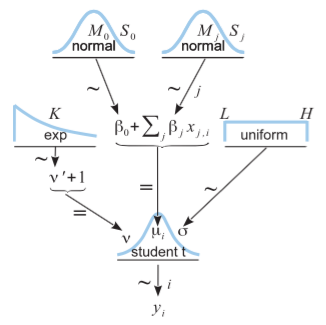

In [6]:
Image('images/fig18_4.png', width=400)

In [7]:
with pm.Model() as model:
    
    zbeta0 = pm.Normal('zbeta0', mu=0, sigma=2)
    #zbeta1 = pm.Normal('zbetaj1', mu=0, sigma=2)
    #zbeta2 = pm.Normal('zbetaj2', mu=0, sigma=2)
    #zmu =  zbeta0 + (zbeta1 * X[:,0]) + (zbeta2 * X[:,1])
    zbetaj = pm.Normal('zbetaj', mu=0, sigma=2, shape=(2))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [8]:
with model:
    idata = pm.sample(10000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [zbeta0, zbetaj, nu, zsigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 51 seconds.


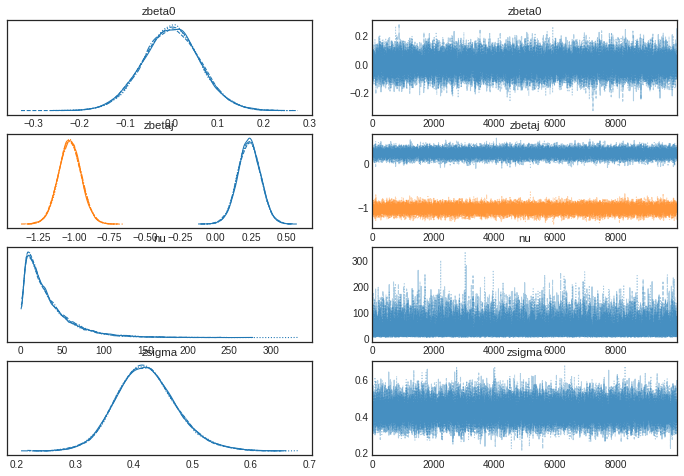

In [9]:
with model:
    az.plot_trace(idata);

#### Figure 18.5

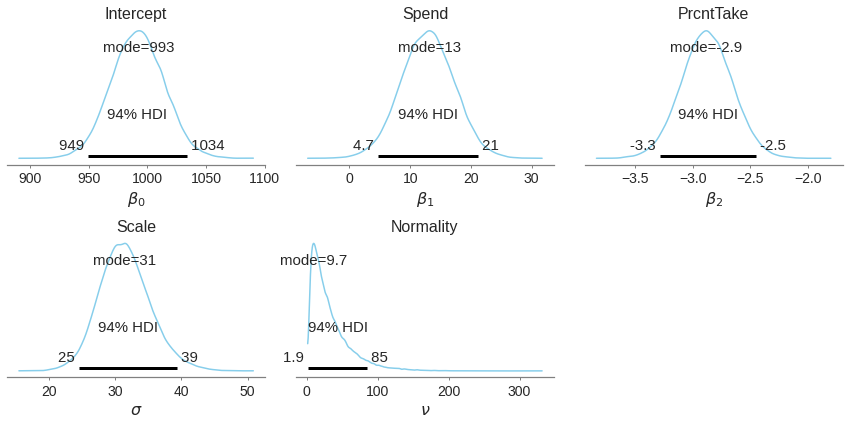

In [10]:
# Transform parameters back to original scale
beta0 = idata.posterior['zbeta0']*scaley + meany - (idata.posterior['zbetaj']*meanx/scalex).sum(axis=2)*scaley
betaj = (idata.posterior['zbetaj']/scalex)*scaley
scale = (idata.posterior['zsigma']*scaley)

intercept = beta0
spend = betaj.sel(zbetaj_dim_0=0)
prcnttake =  betaj.sel(zbetaj_dim_0=1)
#normality = np.log10(trace['nu'])
normality = idata.posterior['nu']

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))


for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\sigma$', r'$\nu$']):
    az.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

fig.tight_layout()
ax6.set_visible(False)

Below we create the scatterplots of figure 18.5 using `pairplot()` in seaborn and then tweak the lower triangle.

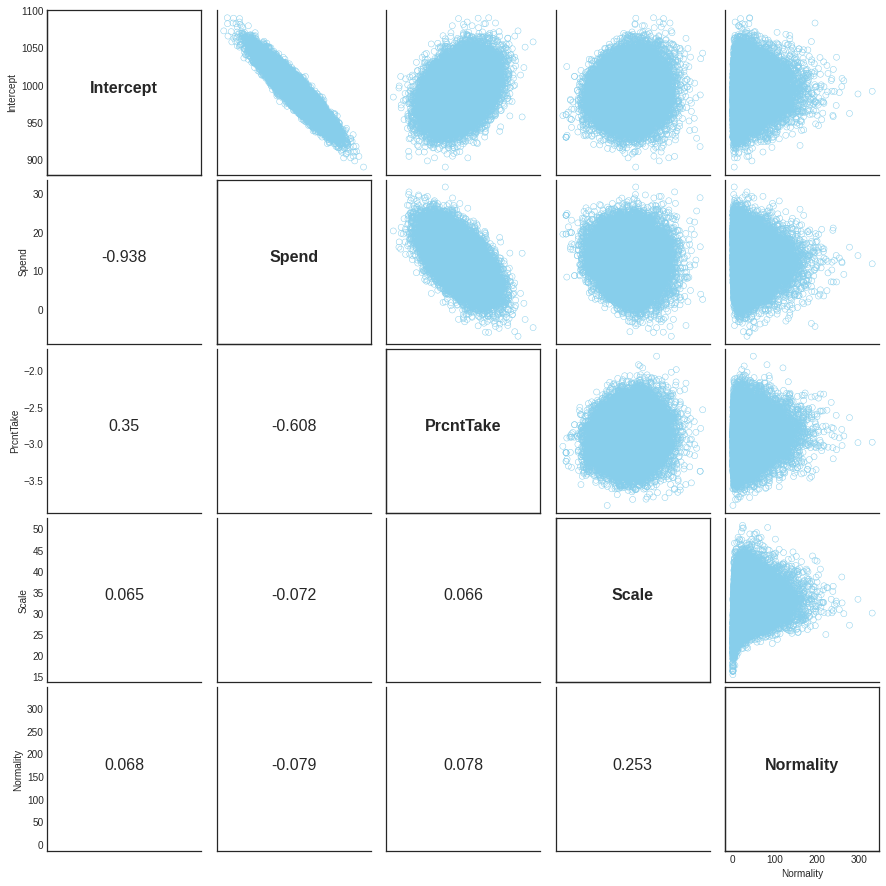

In [11]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept.values.flatten(),
                         'Spend':spend.values.flatten(),
                         'PrcntTake': prcnttake.values.flatten(),
                         'Scale':scale.values.flatten(),
                         'Normality': normality.values.flatten()},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt, rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt, plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    #ax.clear()
    ax.collections[0].remove()
    ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.1.4 - Redundant predictors

In [12]:
X2 = X.assign(PropNotTake = (100-df['PrcntTake']) / 100)

meanx2 = X2.mean().to_numpy()
scalex2 = X2.std().to_numpy()
zX2 = ((X2-meanx2)/scalex2).to_numpy()

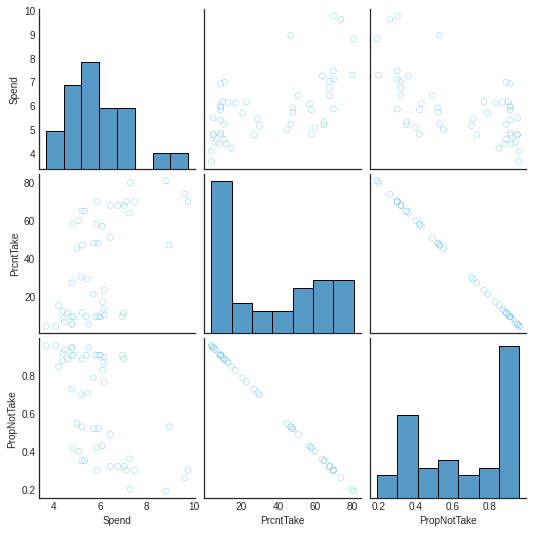

In [13]:
sns.pairplot(X2, plot_kws={'edgecolor':color, 'facecolor':'none'})

In [14]:
with pm.Model() as model2:

    zbeta0 = pm.Normal('zbeta0', mu=0, sigma=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sigma=2, shape=(3))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX2.T)

    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)

    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)    

In [15]:
with model2:
    idata2 = pm.sample(5000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [zbeta0, zbetaj, nu, zsigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 225 seconds.


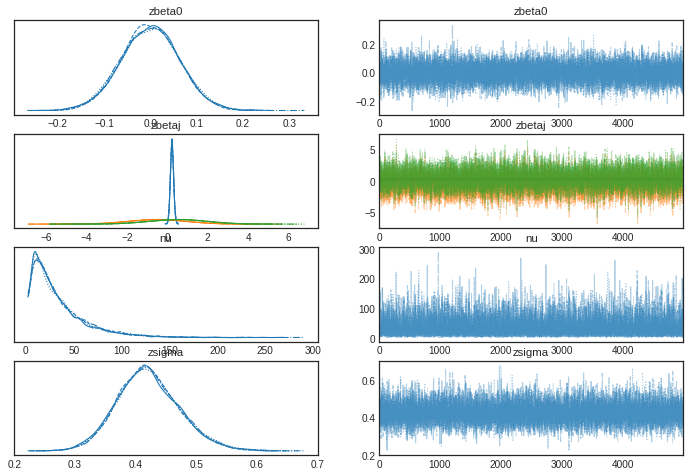

In [16]:
with model2:
    az.plot_trace(idata2);

**Note**: The trace/histogram above for `zbetaj` may look like one of the chains got stuck (i.e., all its values are piled up just above zero).  However, paying attention to the plotting, you can actually tell that it isn't a *chain* that is piled up above zero, it's is one of the parameters in the *array* of parameters stored in `zbetaj`.  Specifically, it is the first parameter, which is the coefficient associated with the *Spend* variable.

#### Figure 18.6

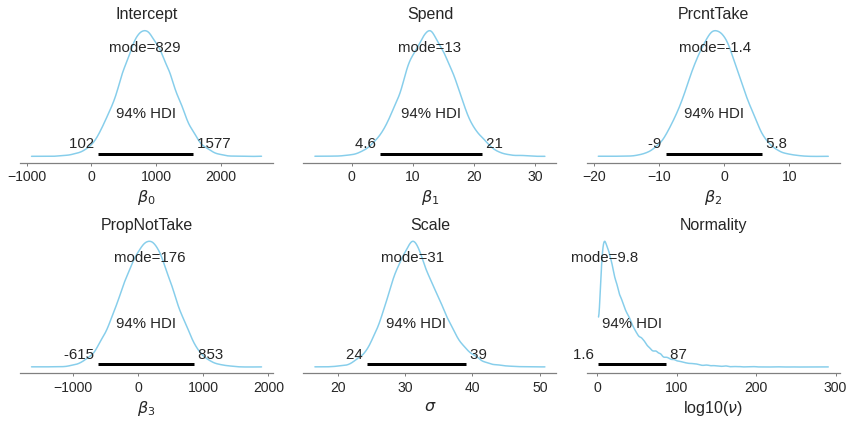

In [17]:
# Transform parameters back to original scale
beta0 = idata2.posterior['zbeta0']*scaley + meany - (idata2.posterior['zbetaj']*meanx2/scalex2).sum(axis=2)*scaley
betaj = (idata2.posterior['zbetaj']/scalex2)*scaley
scale = (idata2.posterior['zsigma']*scaley)

intercept = beta0
spend = betaj.sel(zbetaj_dim_0=0)
prcnttake =  betaj.sel(zbetaj_dim_0=1)
propnottake =  betaj.sel(zbetaj_dim_0=2)
#normality = np.log10(trace2['nu'])
normality = idata2.posterior['nu']

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, propnottake, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'PropNotTake', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\sigma$', r'log10($\nu$)']):
    pm.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

plt.tight_layout()

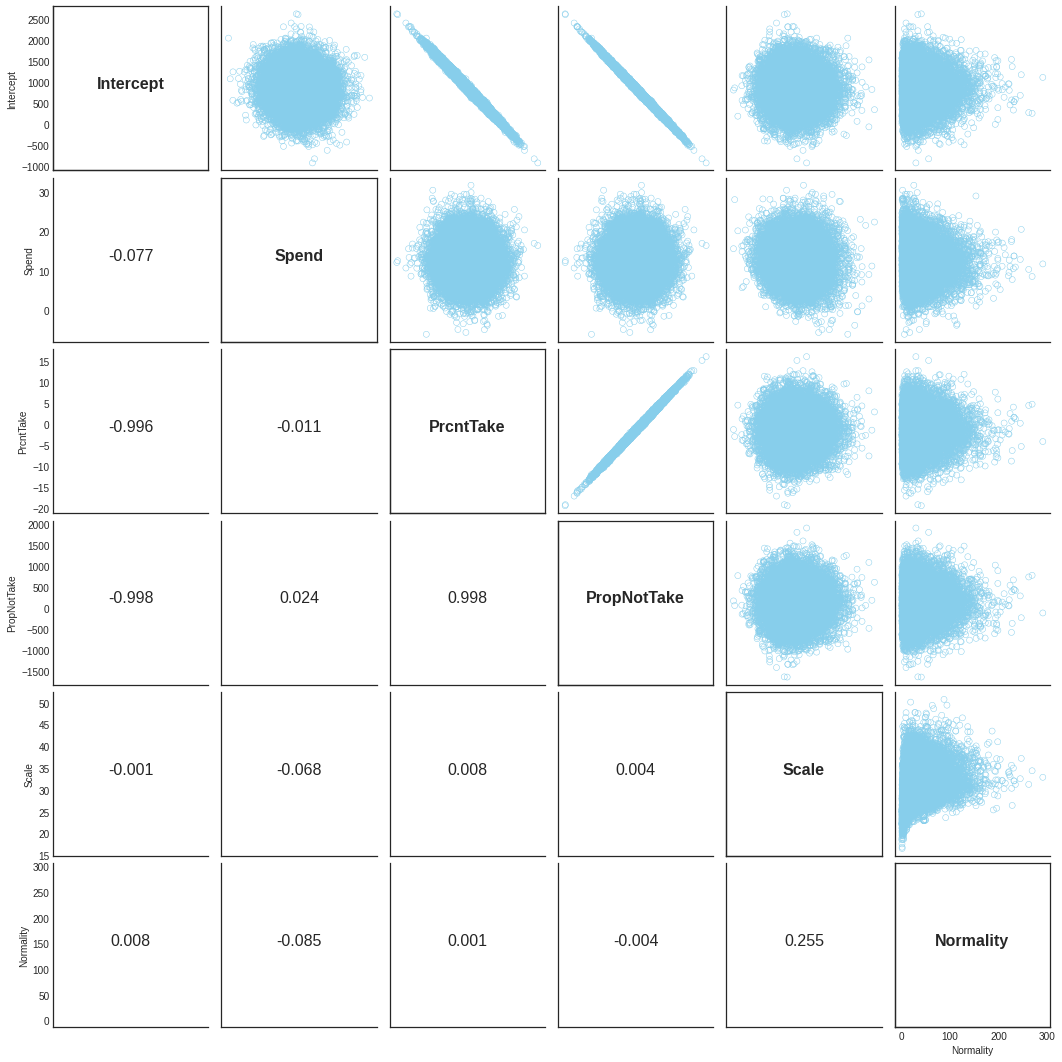

In [18]:
# DataFrame with the columns in correct order
pair_plt = pd.DataFrame({'Intercept':intercept.values.flatten(),
                         'Spend':spend.values.flatten(),
                         'PrcntTake': prcnttake.values.flatten(),
                         'PropNotTake': propnottake.values.flatten(),
                         'Scale':scale.values.flatten(),
                         'Normality': normality.values.flatten()},
                        columns=['Intercept', 'Spend', 'PrcntTake', 'PropNotTake', 'Scale', 'Normality'])

# Correlation coefficients
corr = np.round(np.corrcoef(pair_plt, rowvar=0), decimals=3)
# Indexes of the lower triangle, below the diagonal
lower_idx = np.tril(corr, -1).nonzero()

# The seaborn pairplot
pgrid = sns.pairplot(pair_plt, plot_kws={'edgecolor':color, 'facecolor':'none'})

# Replace the plots on the diagonal with the parameter names
for i, ax in enumerate(pgrid.diag_axes):
    ax.clear()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(.5,.5, pair_plt.columns[i], transform=ax.transAxes, fontdict={'size':16, 'weight':'bold'}, ha='center') 

# Replace the lower triangle with the correlation coefficients
for i, ax in enumerate(pgrid.axes[lower_idx]):
    #ax.clear()
    ax.collections[0].remove()
    ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    ax.text(.5,.5, corr[lower_idx][i], transform=ax.transAxes, fontdict=f_dict, ha='center')

### 18.2 - Multiplicative Interaction of Metric Predictors

In [19]:
X3 = X.assign(SpendXPrcnt = lambda x: x.Spend * x.PrcntTake)

meanx3 = X3.mean().to_numpy()
scalex3 = X3.std().to_numpy()
zX3 = ((X3-meanx3)/scalex3).to_numpy()

In [20]:
# Correlation matrix
X3.corr()

,Spend,PrcntTake,SpendXPrcnt
Spend,1.000000,0.592627,0.775025
PrcntTake,0.592627,1.000000,0.951146
SpendXPrcnt,0.775025,0.951146,1.000000


In [21]:
with pm.Model() as model3:

    zbeta0 = pm.Normal('zbeta0', mu=0, sigma=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sigma=2, shape=(3))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX3.T)

    nu = pm.Exponential('nu', 1/30.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)

    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy)

In [22]:
with model3:
    idata3 = pm.sample(20000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [zbeta0, zbetaj, nu, zsigma]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 238 seconds.


#### Figure 18.9

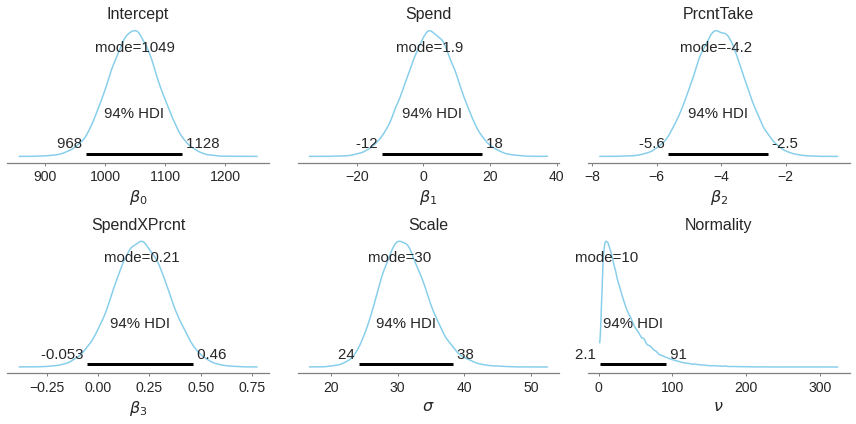

In [23]:
# Transform parameters back to original scale
beta0 = idata3.posterior['zbeta0']*scaley + meany - (idata3.posterior['zbetaj']*meanx3/scalex3).sum(axis=2)*scaley
betaj = (idata3.posterior['zbetaj']/scalex3)*scaley
scale = (idata3.posterior['zsigma']*scaley)

intercept = beta0
spend = betaj.sel(zbetaj_dim_0=0)
prcnttake =  betaj.sel(zbetaj_dim_0=1)
spendxprcnt =  betaj.sel(zbetaj_dim_0=2)
#normality = np.log10(trace3['nu'])
normality = idata3.posterior['nu']

fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,6))

for ax, estimate, title, xlabel in zip(fig.axes,
                               [intercept, spend, prcnttake, spendxprcnt, scale, normality],
                               ['Intercept', 'Spend', 'PrcntTake', 'SpendXPrcnt', 'Scale', 'Normality'],
                               [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\sigma$', r'$\nu$']):
    az.plot_posterior(estimate, point_estimate='mode', ax=ax, color=color)
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(xlabel, fontdict=f_dict)

plt.tight_layout()

In [24]:
spendxprcnt

<xarray.DataArray 'zbetaj' (chain: 4, draw: 20000)>
array([[0.19207617, 0.2992751 , 0.18738506, ..., 0.29172019, 0.28161156,
        0.38165063],
       [0.03064289, 0.02294307, 0.22319585, ..., 0.33277579, 0.39780397,
        0.36394119],
       [0.11321359, 0.08293248, 0.28097526, ..., 0.25980066, 0.25964787,
        0.3719313 ],
       [0.42862678, 0.43541406, 0.36774806, ..., 0.14847174, 0.218636  ,
        0.34816949]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 ... 19995 19996 19997 19998 19999
    zbetaj_dim_0  int64 2

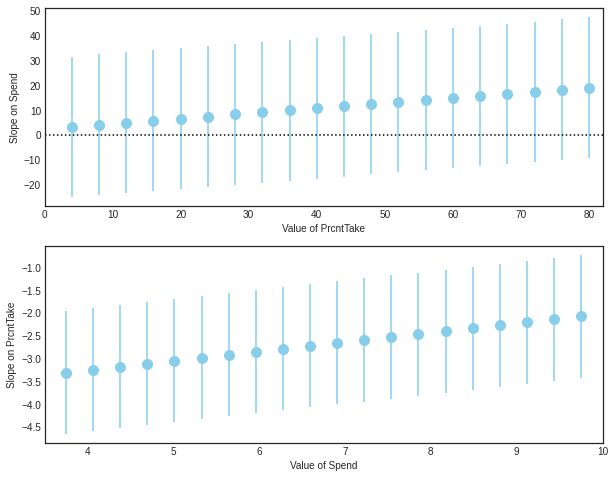

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

# Slope on Spend
prcnttake_values = np.linspace(4, 80, 20).reshape(1,-1)
spend_slope = spend.values.flatten() + spendxprcnt.values.flatten()*prcnttake_values.reshape(-1,1)
hpds = np.array([az.hdi(spend_slope[i,:]) for i in range(len(prcnttake_values))])
spend_slope_medians = spend_slope.mean(axis=1)

ax1.errorbar(prcnttake_values.ravel(), spend_slope_medians, yerr=hpds[:,1]-hpds[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax1.axhline(linestyle='dotted', color='k')
ax1.set_xlim(0,82)
ax1.set(xlabel='Value of PrcntTake', ylabel='Slope on Spend')

# Slope on PrcntTake
spend_values = np.linspace(3.75, 9.75, 20)
prcnttake_slope = prcnttake.values.flatten() + spendxprcnt.values.flatten()*spend_values.reshape(-1,1)
hpds2 = np.array([az.hdi(prcnttake_slope[i,:]) for i in range(len(prcnttake_values))])
prcnttake_slope_medians = prcnttake_slope.mean(axis=1)

ax2.errorbar(spend_values.ravel(), prcnttake_slope_medians, yerr=hpds2[:,1]-hpds2[:,0],
             color=color, linestyle='None', marker='o', markersize=10)
ax2.set_xlim(3.5,10)
ax2.set(xlabel='Value of Spend', ylabel='Slope on PrcntTake');

### 18.3 - Shrinkage of Regression Coefficients

In *`R`* I ran the first 46 lines of code in the script `Jags-Ymet-XmetMulti-MrobustShrink-Example.R` to generate the exact same data used in the book. I exported the resulting data frame `myData` to a csv file.

In [26]:
df_shrink = pd.read_csv('data/18_3shrinkage.csv')
df_shrink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      50 non-null     object 
 1   Spend      50 non-null     float64
 2   StuTeaRat  50 non-null     float64
 3   Salary     50 non-null     float64
 4   PrcntTake  50 non-null     int64  
 5   SATV       50 non-null     int64  
 6   SATM       50 non-null     int64  
 7   SATT       50 non-null     int64  
 8   xRand1     50 non-null     float64
 9   xRand2     50 non-null     float64
 10  xRand3     50 non-null     float64
 11  xRand4     50 non-null     float64
 12  xRand5     50 non-null     float64
 13  xRand6     50 non-null     float64
 14  xRand7     50 non-null     float64
 15  xRand8     50 non-null     float64
 16  xRand9     50 non-null     float64
 17  xRand10    50 non-null     float64
 18  xRand11    50 non-null     float64
 19  xRand12    50 non-null     float64
dtypes: float64(1

In [27]:
# check bivariate associations between SATT and other variables
df_shrink.corrwith(df_shrink['SATT'])

Spend       -0.380537
StuTeaRat    0.081254
Salary      -0.439883
PrcntTake   -0.887119
SATV         0.991503
SATM         0.993502
SATT         1.000000
xRand1       0.061227
xRand2      -0.133041
xRand3       0.089269
xRand4      -0.091886
xRand5       0.169029
xRand6       0.089121
xRand7      -0.003979
xRand8      -0.063501
xRand9       0.003417
xRand10     -0.239786
xRand11      0.030958
xRand12      0.315480
dtype: float64

In [28]:
# Select the predictor columns: Spend, PrcntTake and the 12 randonly generated predictors
#X4 = df_shrink.iloc[:, np.r_[[1,4], np.arange(8,20)]]
X4 = df_shrink.drop(columns=['State','StuTeaRat', 'Salary', 'SATV', 'SATM', 'SATT'])
y4 = df_shrink.SATT

meanx4 = X4.mean().to_numpy()
scalex4 = X4.std().to_numpy()
zX4 = ((X4-meanx4)/scalex4).to_numpy()

meany4 = y4.mean()
scaley4 = y4.std()
zy4 = ((y4-meany4)/scaley4).to_numpy()

##### Hierarchical model with fixed, independent, vague normal priors

#### Model (Kruschke, 2015)

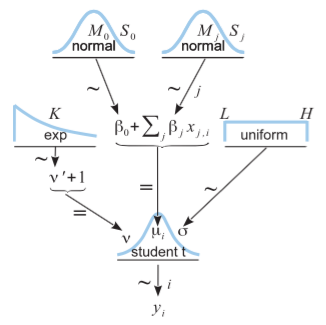

In [29]:
Image('images/fig18_4.png', width=400)

In [30]:
with pm.Model() as model4:

    zbeta0 = pm.Normal('zbeta0', mu=0, sigma=2)
    zbetaj = pm.Normal('zbetaj', mu=0, sigma=2, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX4.T)

    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)

    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

In [31]:
with model4:
    idata4 = pm.sample(5000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [zbeta0, zbetaj, nu, zsigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 38 seconds.


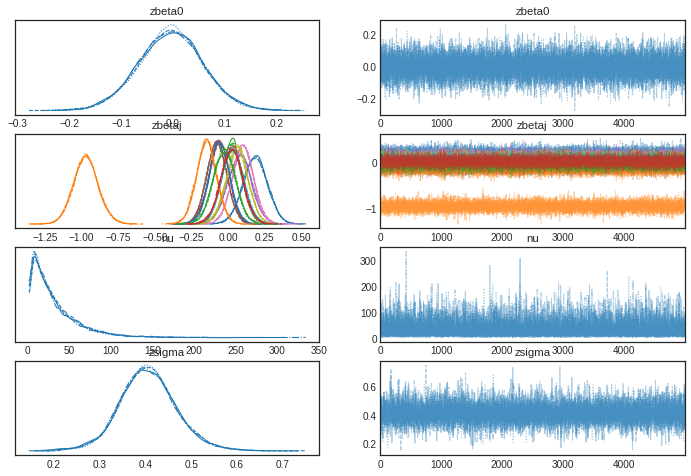

In [32]:
with model4:
    az.plot_trace(idata4);

In [33]:
# probability that the spend coefficient is greater than zero
(idata4.posterior['zbetaj'].sel(zbetaj_dim_0=0) > 0).mean()

<xarray.DataArray 'zbetaj' ()>
array(0.98425)
Coordinates:
    zbetaj_dim_0  int64 0

#### Figure 18.11

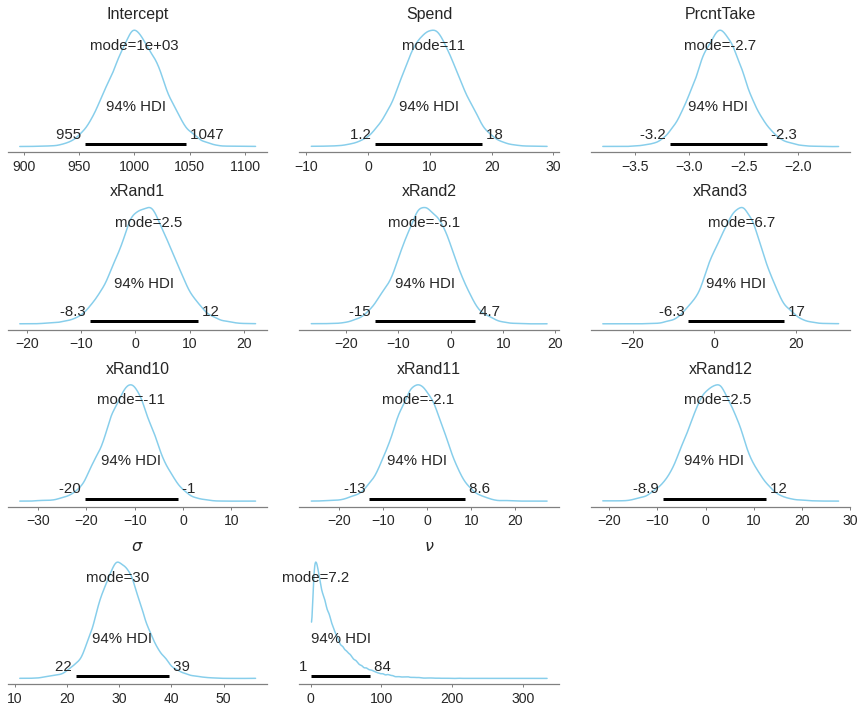

In [34]:
# Transform parameters back to original scale
beta0 = idata4.posterior['zbeta0']*scaley4 + meany4 - (idata4.posterior['zbetaj']*meanx4/scalex4).sum(axis=2)*scaley4
betaj = (idata4.posterior['zbetaj']/scalex4)*scaley4
scale = (idata4.posterior['zsigma']*scaley4)

intercept = beta0
spend = betaj.sel(zbetaj_dim_0=0)
prcnttake =  betaj.sel(zbetaj_dim_0=1)
#normality = np.log10(idata4.posterior['nu'])
normality = idata4.posterior['nu']

fig, axes = plt.subplots(4,3, figsize=(12,10))

# Intercept
pm.plot_posterior(intercept, point_estimate='mode', ax=axes.flatten()[0], color=color)
axes.flatten()[0].set_title('Intercept', fontdict=f_dict)

# Spend & PrcntTale
pm.plot_posterior(spend, point_estimate='mode', ax=axes.flatten()[1], color=color)
axes.flatten()[1].set_title('Spend', fontdict=f_dict)
az.plot_posterior(prcnttake, point_estimate='mode', ax=axes.flatten()[2], color=color)
axes.flatten()[2].set_title('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
for ax, j in enumerate([2,3,4,11,12,13]):
    pm.plot_posterior(betaj.sel(zbetaj_dim_0=j), point_estimate='mode', ax=axes.flatten()[ax+3], color=color)
    axes.flatten()[ax+3].set_title(X4.columns[j], fontdict=f_dict)

# Scale
az.plot_posterior(scale, point_estimate='mode', ax=axes.flatten()[9], color=color)
axes.flatten()[9].set_title(r'$\sigma$', fontdict=f_dict)

# Normality
az.plot_posterior(normality, point_estimate='mode', ax=axes.flatten()[10], color=color)
axes.flatten()[10].set_title(r'$\nu$', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

fig.tight_layout()

In [35]:
with pm.Model() as model5:

    zbeta0 = pm.Normal('zbeta0', mu=0, sigma=2)
    zbetajscale = pm.Gamma('zbetajscale', mu=1, sigma=1)
    zbetaj = pm.StudentT('zbetaj', mu=0, sigma=zbetajscale, nu=1, shape=(zX4.shape[1]))
    zmu =  zbeta0 + pm.math.dot(zbetaj, zX4.T)

    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)

    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=zy4)

In [36]:
with model5:
    idata5 = pm.sample(10000, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/xian/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [zbeta0, zbetajscale, zbetaj, nu, zsigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 113 seconds.


In [37]:
# probability that the spend coefficient is greater than zero
(idata5.posterior['zbetaj'].sel(zbetaj_dim_0=0) > 0).mean()

<xarray.DataArray 'zbetaj' ()>
array(0.931775)
Coordinates:
    zbetaj_dim_0  int64 0

#### Figure 18.12

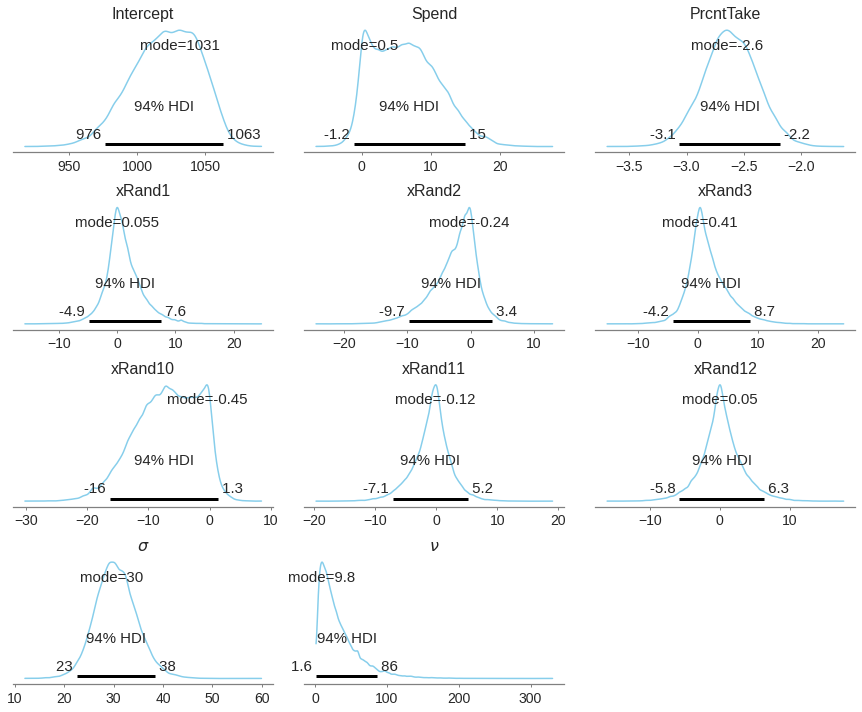

In [38]:
# Transform parameters back to original scale
beta0 = idata5.posterior['zbeta0']*scaley4 + meany4 - (idata5.posterior['zbetaj']*meanx4/scalex4).sum(axis=2)*scaley4
betaj = (idata5.posterior['zbetaj']/scalex4)*scaley4
scale = (idata5.posterior['zsigma']*scaley4)

intercept = beta0
spend = betaj.sel(zbetaj_dim_0=0)
prcnttake =  betaj.sel(zbetaj_dim_0=1)
#normality = np.log10(idata5.posterior['nu'])
normality = idata5.posterior['nu']

fig, axes = plt.subplots(4,3, figsize=(12,10))

# Intercept
pm.plot_posterior(intercept, point_estimate='mode', ax=axes.flatten()[0], color=color)
axes.flatten()[0].set_title('Intercept', fontdict=f_dict)

# Spend & PrcntTale
pm.plot_posterior(spend, point_estimate='mode', ax=axes.flatten()[1], color=color)
axes.flatten()[1].set_title('Spend', fontdict=f_dict)
az.plot_posterior(prcnttake, point_estimate='mode', ax=axes.flatten()[2], color=color)
axes.flatten()[2].set_title('PrcntTake', fontdict=f_dict)

# Randomly generated predictors
for ax, j in enumerate([2,3,4,11,12,13]):
    pm.plot_posterior(betaj.sel(zbetaj_dim_0=j), point_estimate='mode', ax=axes.flatten()[ax+3], color=color)
    axes.flatten()[ax+3].set_title(X4.columns[j], fontdict=f_dict)

# Scale
az.plot_posterior(scale, point_estimate='mode', ax=axes.flatten()[9], color=color)
axes.flatten()[9].set_title(r'$\sigma$', fontdict=f_dict)

# Normality
az.plot_posterior(normality, point_estimate='mode', ax=axes.flatten()[10], color=color)
axes.flatten()[10].set_title(r'$\nu$', fontdict=f_dict);

axes.flatten()[11].set_visible(False)

fig.tight_layout()